In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import matplotlib.path as mpath

In [16]:
file_path = "ERA5_SST_3h_monmean_7923.nc"

In [17]:
ds = xr.open_dataset(file_path)
ds.head()

<xarray.Dataset>
Dimensions:    (time: 5, bnds: 2, longitude: 5, latitude: 5)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-16T10:00:00 ... 1979-05-16T10:00:00
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 1.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 89.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Nov 08 16:34:03 2024: cdo monmean ERA5_SST_3h_daymean_7...
    frequency:    mon
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

In [3]:
sst_data = ds['sst']
sst_data.head()

<xarray.DataArray 'sst' (time: 5, latitude: 5, longitude: 5)>
[125 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1979-01-16T10:00:00 ... 1979-05-16T10:00:00
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 1.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 89.0
Attributes:
    long_name:     Sea surface temperature
    units:         K
    cell_methods:  time: mean

In [4]:
sst_data_celsius = sst_data - 273.15
sst_data_celsius.head()

<xarray.DataArray 'sst' (time: 5, latitude: 5, longitude: 5)>
array([[[-1.6900635, -1.6900635, -1.6900635, -1.6900635, -1.6900635],
        [-1.6900635, -1.6900635, -1.6900635, -1.6900635, -1.6900635],
        [-1.6900635, -1.6900635, -1.6900635, -1.6900635, -1.6900635],
        [-1.6900635, -1.6900635, -1.6900635, -1.6900635, -1.6900635],
        [-1.6900635, -1.6900635, -1.6900635, -1.6900635, -1.6900635]],

       [[-1.6899719, -1.6899719, -1.6899719, -1.6899719, -1.6899719],
        [-1.6899719, -1.6899719, -1.6899719, -1.6899719, -1.6899719],
        [-1.6899719, -1.6899719, -1.6899719, -1.6899719, -1.6899719],
        [-1.6899719, -1.6899719, -1.6899719, -1.6899719, -1.6899719],
        [-1.6899719, -1.6899719, -1.6899719, -1.6899719, -1.6899719]],

       [[-1.6897888, -1.6897888, -1.6897888, -1.6897888, -1.6897888],
        [-1.6897888, -1.6897888, -1.6897888, -1.6897888, -1.6897888],
        [-1.6897888, -1.6897888, -1.6897888, -1.6897888, -1.6897888],
        [-1.6897888, -1.6897888, -1.6897888, -1.6897888, -1.6897888],
        [-1.6897888, -1.6897888, -1.6897888, -1.6897888, -1.6897888]],

       [[-1.6898804, -1.6898804, -1.6898804, -1.6898804, -1.6898804],
        [-1.6898804, -1.6898804, -1.6898804, -1.6898804, -1.6898804],
        [-1.6898804, -1.6898804, -1.6898804, -1.6898804, -1.6898804],
        [-1.6898804, -1.6898804, -1.6898804, -1.6898804, -1.6898804],
        [-1.6898804, -1.6898804, -1.6898804, -1.6898804, -1.6898804]],

       [[-1.6898193, -1.6898193, -1.6898193, -1.6898193, -1.6898193],
        [-1.6898193, -1.6900635, -1.6898804, -1.6898193, -1.6898193],
        [-1.6898193, -1.6898193, -1.6898193, -1.6898193, -1.6898193],
        [-1.6898193, -1.6898193, -1.6898193, -1.6898193, -1.6898193],
        [-1.6898193, -1.6898193, -1.6901245, -1.6898193, -1.6898193]]],
      dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-16T10:00:00 ... 1979-05-16T10:00:00
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 1.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 89.0

# 1. Train test Split

In [5]:
sst_series = sst_data_celsius.mean(dim=["latitude", "longitude"]).to_series()  # Spatially averaged SST
sst_series = sst_series.dropna()
sst_series.head()

time
1979-01-16 10:00:00    13.604650
1979-02-14 22:00:00    13.709523
1979-03-16 10:00:00    13.688480
1979-04-15 22:00:00    13.601407
1979-05-16 10:00:00    13.475532
Name: sst, dtype: float32

In [6]:
train_ratio = 0.8
train_size = int(len(sst_series) * train_ratio)

train_data = sst_series[:train_size]
test_data = sst_series[train_size:]

In [7]:
np.random.seed(42)
data = np.cumsum(np.random.randn(100))

In [8]:
# train_data.index = pd.DatetimeIndex(train_data.index).to_period('M')
model = AutoReg(train_data, lags=12)
model_fit = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [9]:
start = len(train_data)
end = len(train_data) + len(test_data) - 1
predictions = model_fit.predict(start=start, end=end)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


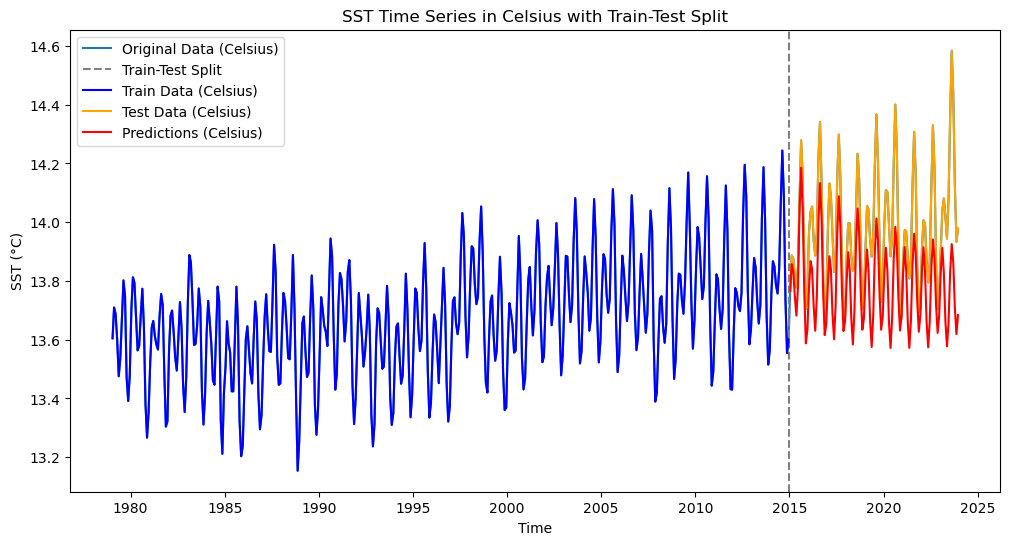

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(sst_series, label="Original Data (Celsius)")
plt.axvline(x=train_data.index[-1], color='gray', linestyle="--", label="Train-Test Split")
plt.plot(train_data, label="Train Data (Celsius)", color="blue")
plt.plot(test_data, label="Test Data (Celsius)", color="orange")
plt.plot(test_data.index, predictions, label="Predictions (Celsius)", color="red")
plt.legend()
plt.title("SST Time Series in Celsius with Train-Test Split")
plt.xlabel("Time")
plt.ylabel("SST (°C)")
plt.show()

In [11]:
mse = mean_squared_error(test_data, predictions)
print(f"Mean Squared Error on Test Data: {mse:.4f}")

Mean Squared Error on Test Data: 0.0518


# 2. Moving Average

Mean Squared Error (MSE): 0.0362


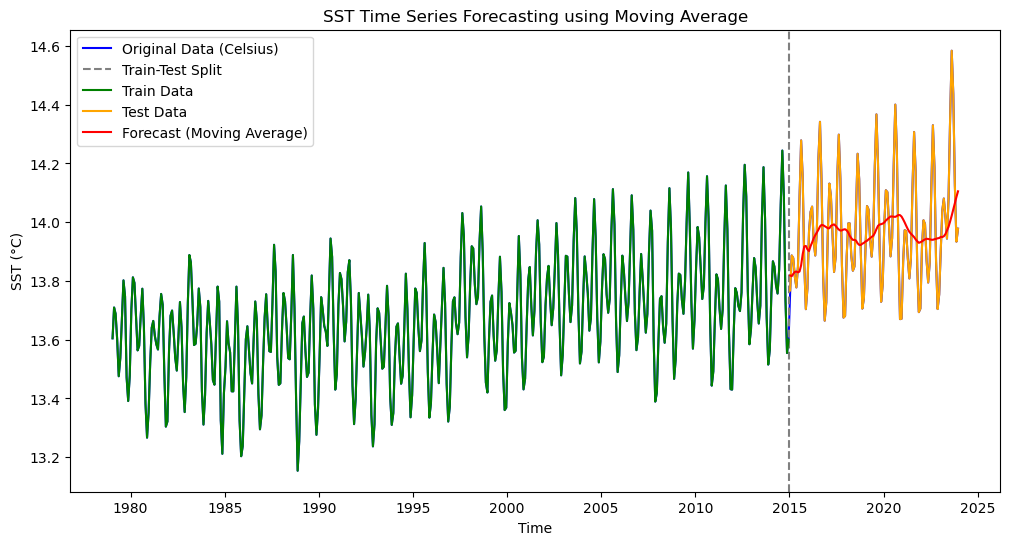

In [24]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def load_data(file_path):
    ds = xr.open_dataset(file_path)
    sst_data = ds['sst']
    sst_data_celsius = sst_data - 273.15
    return sst_data_celsius.mean(dim=["latitude", "longitude"]).to_series().dropna()

def train_test_split(data, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data

def moving_average_forecast(train_data, test_data, window_size=12):
    train_moving_avg = train_data.rolling(window=window_size, min_periods=1).mean()
    forecast = []
    for i in range(len(test_data)):
        forecast.append(train_moving_avg.iloc[-window_size:].mean())
        train_moving_avg = pd.concat([train_moving_avg, pd.Series(test_data.iloc[i])])
    return forecast

def plot_results(sst_series, train_data, test_data, forecast):
    plt.figure(figsize=(12, 6))
    plt.plot(sst_series, label="Original Data (Celsius)", color="blue")
    plt.axvline(x=train_data.index[-1], color="gray", linestyle="--", label="Train-Test Split")
    plt.plot(train_data, label="Train Data", color="green")
    plt.plot(test_data, label="Test Data", color="orange")
    plt.plot(test_data.index, forecast, label="Forecast (Moving Average)", color="red")
    plt.legend()
    plt.title(f"SST Time Series Forecasting using Moving Average")
    plt.xlabel("Time")
    plt.ylabel("SST (°C)")
    plt.show()

def evaluate_performance(test_data, forecast):
    mse = mean_squared_error(test_data, forecast)
    print(f"Mean Squared Error (MSE): {mse:.4f}")

def main(file_path="ERA5_SST_3h_monmean_7923.nc"):
    sst_series = load_data(file_path)
    train_data, test_data = train_test_split(sst_series)
    forecast = moving_average_forecast(train_data, test_data)
    evaluate_performance(test_data, forecast)
    plot_results(sst_series, train_data, test_data, forecast)

main()

# 3. ARMA Model

In [31]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [32]:
file_path = "ERA5_SST_3h_monmean_7923.nc"
ds = xr.open_dataset(file_path)

In [33]:
sst_data = ds['sst']

In [34]:
sst_data_celsius = sst_data - 273.15

In [35]:
sst_series = sst_data_celsius.mean(dim=["latitude", "longitude"]).to_series()
sst_series = sst_series.dropna()

In [36]:
train_ratio = 0.8
train_size = int(len(sst_series) * train_ratio)

In [37]:
train_data = sst_series[:train_size]
test_data = sst_series[train_size:]

In [38]:
p = 12
q = 12

In [39]:
model = ARIMA(train_data, order=(p, 0, q))
model_fit = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

In [40]:
predictions = model_fit.forecast(steps=len(test_data))

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [41]:
mse = mean_squared_error(test_data, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0394


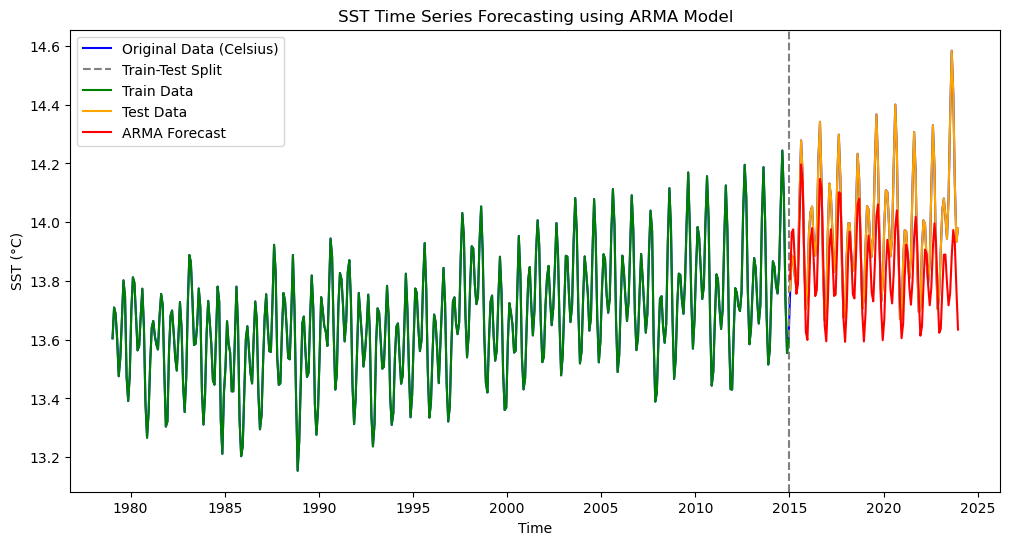

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(sst_series, label="Original Data (Celsius)", color="blue")
plt.axvline(x=train_data.index[-1], color="gray", linestyle="--", label="Train-Test Split")
plt.plot(train_data, label="Train Data", color="green")
plt.plot(test_data, label="Test Data", color="orange")
plt.plot(test_data.index, predictions, label="ARMA Forecast", color="red")
plt.legend()
plt.title("SST Time Series Forecasting using ARMA Model")
plt.xlabel("Time")
plt.ylabel("SST (°C)")
plt.show()

# 4. ARIMA Model

In [44]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [45]:
file_path = "ERA5_SST_3h_monmean_7923.nc"
ds = xr.open_dataset(file_path)

In [46]:
sst_data = ds['sst']

In [47]:
sst_data_celsius = sst_data - 273.15

In [48]:
sst_series = sst_data_celsius.mean(dim=["latitude", "longitude"]).to_series()
sst_series = sst_series.dropna()

In [49]:
train_ratio = 0.8
train_size = int(len(sst_series) * train_ratio)

In [50]:
train_data = sst_series[:train_size]
test_data = sst_series[train_size:]

In [51]:
p = 12
d = 1
q = 12

In [52]:
model = ARIMA(train_data, order=(p, d, q))
model_fit = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

In [53]:
predictions = model_fit.forecast(steps=len(test_data))

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [54]:
mse = mean_squared_error(test_data, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0352


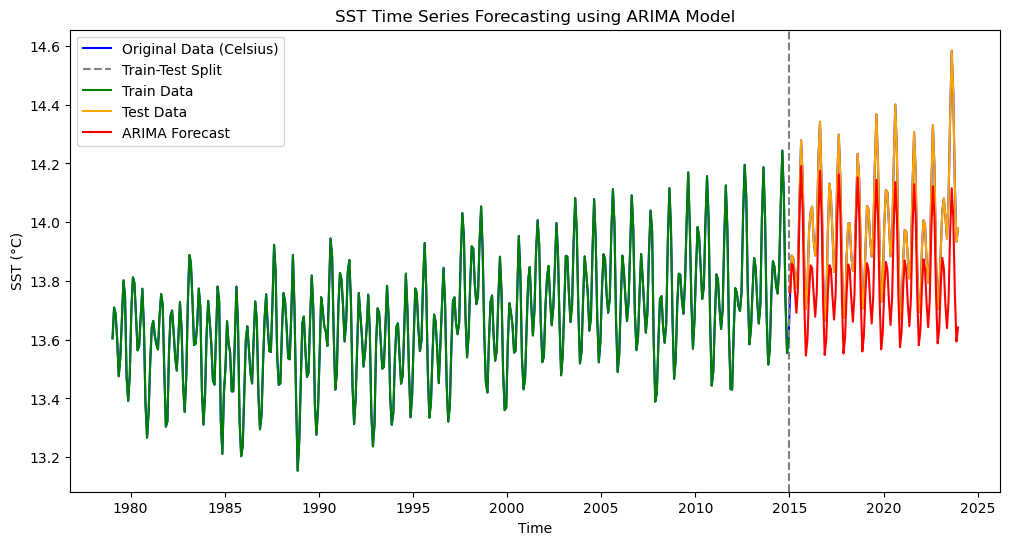

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(sst_series, label="Original Data (Celsius)", color="blue")
plt.axvline(x=train_data.index[-1], color="gray", linestyle="--", label="Train-Test Split")
plt.plot(train_data, label="Train Data", color="green")
plt.plot(test_data, label="Test Data", color="orange")
plt.plot(test_data.index, predictions, label="ARIMA Forecast", color="red")
plt.legend()
plt.title("SST Time Series Forecasting using ARIMA Model")
plt.xlabel("Time")
plt.ylabel("SST (°C)")
plt.show()

# 5. SARIMA Model

In [56]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [57]:
file_path = "ERA5_SST_3h_monmean_7923.nc"
ds = xr.open_dataset(file_path)

In [58]:
sst_data = ds['sst']

In [59]:
sst_data_celsius = sst_data - 273.15

In [60]:
sst_series = sst_data_celsius.mean(dim=["latitude", "longitude"]).to_series()
sst_series = sst_series.dropna()

In [61]:
train_ratio = 0.8
train_size = int(len(sst_series) * train_ratio)

In [62]:
train_data = sst_series[:train_size]
test_data = sst_series[train_size:]

In [63]:
p = 6
d = 1
q = 6
P = 3
D = 1
Q = 3
m = 12

In [64]:
model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           19     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.79030D+00    |proj g|=  7.80847D+00

At iterate    5    f= -1.83336D+00    |proj g|=  1.09628D-01

At iterate   10    f= -1.84588D+00    |proj g|=  7.04682D-02

At iterate   15    f= -1.84762D+00    |proj g|=  6.09328D-01

At iterate   20    f= -1.84958D+00    |proj g|=  8.57093D-01

At iterate   25    f= -1.85093D+00    |proj g|=  5.21622D-02

At iterate   30    f= -1.85215D+00    |proj g|=  1.36464D-01

At iterate   35    f= -1.85485D+00    |proj g|=  8.02611D-02

At iterate   40    f= -1.86003D+00    |proj g|=  9.76837D-02

At iterate   45    f= -1.86185D+00    |proj g|=  7.09793D-02


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f= -1.86685D+00    |proj g|=  1.16711D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   19     50     59      1     0     0   1.167D+00  -1.867D+00
  F =  -1.8668498982592407     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [65]:
predictions = model_fit.forecast(steps=len(test_data))

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [66]:
mse = mean_squared_error(test_data, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.0181


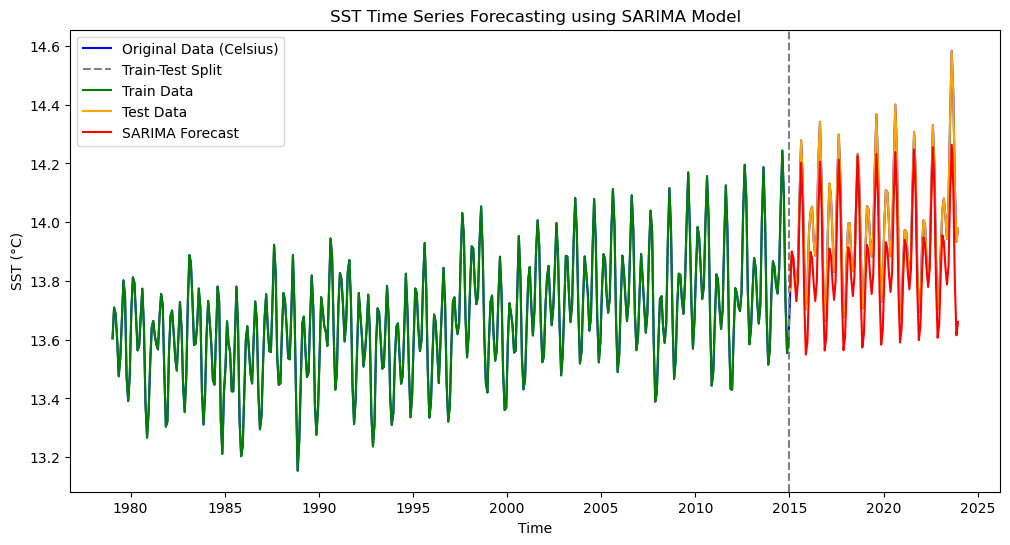

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(sst_series, label="Original Data (Celsius)", color="blue")
plt.axvline(x=train_data.index[-1], color="gray", linestyle="--", label="Train-Test Split")
plt.plot(train_data, label="Train Data", color="green")
plt.plot(test_data, label="Test Data", color="orange")
plt.plot(test_data.index, predictions, label="SARIMA Forecast", color="red")
plt.legend()
plt.title("SST Time Series Forecasting using SARIMA Model")
plt.xlabel("Time")
plt.ylabel("SST (°C)")
plt.show()